In [89]:
import os
import numpy as np
import pandas as pd

# Load the data from file
def load_data(file_path):
    with open(file_path, 'r') as f:
        # Read first line (contains sampling rate and duration)
        first_line = f.readline().strip()
        # Extract sampling rate and duration
        try:
            sampling_rate = int(first_line.split('Sampling Rate : ')[1].split('Hz')[0].strip())
            duration = first_line.split('Duration : ')[1].split()[0].strip()
        except (IndexError, ValueError):
            print(f"Error parsing sampling rate and duration in {file_path}")
            return None, None, None
        
        # Read second line onward (contains time and PPG data)
        # Skip the first row of data (since we read it already)
        data = pd.read_csv(f, header=None, names=['Time', 'PPG'], skiprows=0)
        
        # Convert columns to proper data types (remove any non-numeric rows)
        try:
            data['Time'] = pd.to_numeric(data['Time'], errors='coerce')
            data['PPG'] = pd.to_numeric(data['PPG'], errors='coerce')
        except ValueError:
            print(f"Error processing data in {file_path}")
            return None, None, None
        
        # Drop rows where conversion failed
        data = data.dropna(subset=['Time', 'PPG'])
        
    return data, sampling_rate, duration

# Directory where datasets are stored
data_dir = "../data"

# List of dataset files
dataset_files = ["PPG-1.csv", "PPG-2.csv", "PPG-3.csv", "PPG-4.csv", "PPG-6.csv"]

# Dictionary to store loaded datasets
datasets = {}

# Load each dataset
for file_name in dataset_files:
    file_path = os.path.join(data_dir, file_name)
    data, sampling_rate, duration = load_data(file_path)
    
    # Store the dataset information if loading is successful
    if data is not None and sampling_rate is not None and duration is not None:
        ppg_signal = data['PPG'].values
        datasets[file_name] = {
            'data': data,
            'sampling_rate': sampling_rate,
            'duration': duration,
            'ppg_signal': ppg_signal
        }

# Check the loaded datasets
for file_name, info in datasets.items():
    print(f"Dataset: {file_name}, Sampling Rate: {info['sampling_rate']} Hz, Duration: {info['duration']} Minutes")


Dataset: PPG-1.csv, Sampling Rate: 125 Hz, Duration: 20 Minutes
Dataset: PPG-2.csv, Sampling Rate: 125 Hz, Duration: 20 Minutes
Dataset: PPG-3.csv, Sampling Rate: 100 Hz, Duration: 3 Minutes
Dataset: PPG-4.csv, Sampling Rate: 100 Hz, Duration: 210 Minutes
Dataset: PPG-6.csv, Sampling Rate: 128 Hz, Duration: 10 Minutes


In [90]:
# Check the column names of the dataset to ensure there are no issues
print(df1.columns)


Index(['Time', 'PPG'], dtype='object')


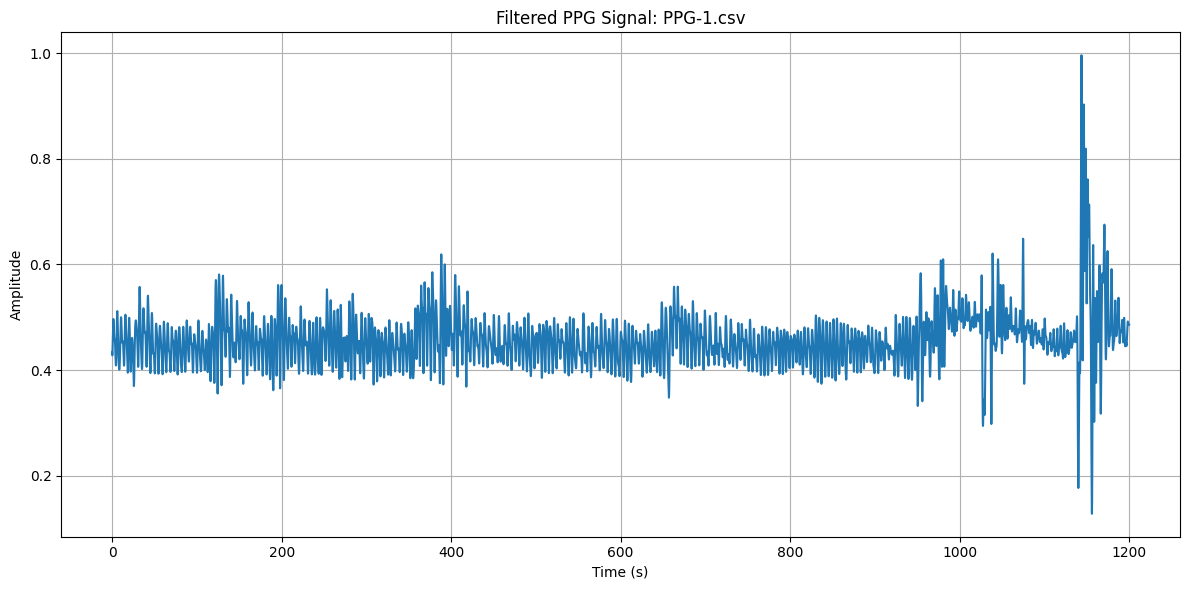

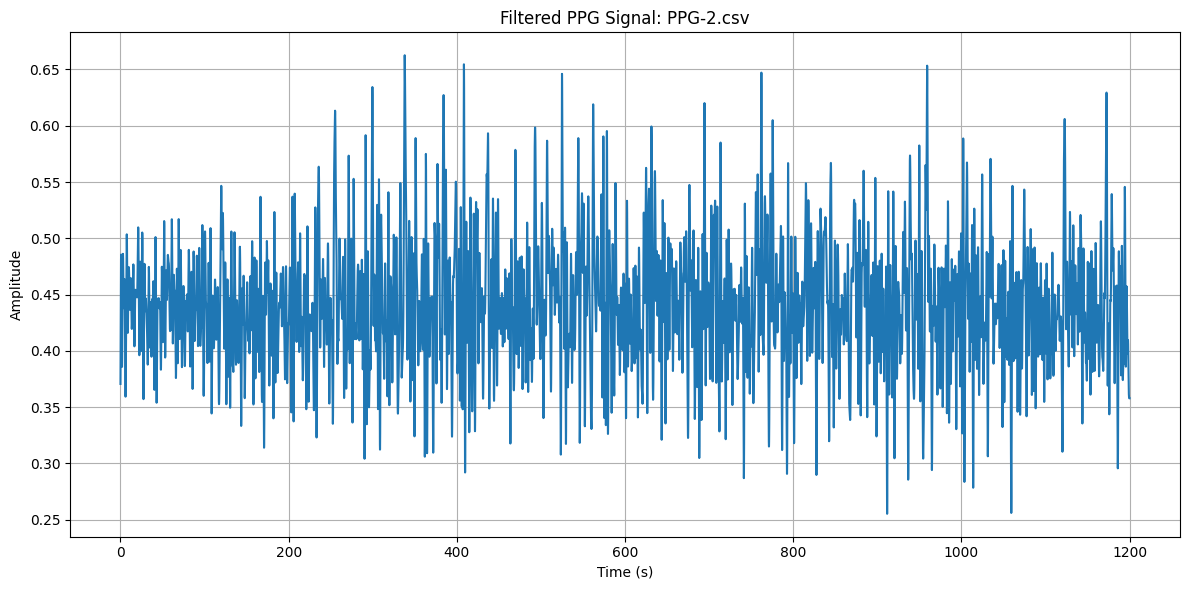

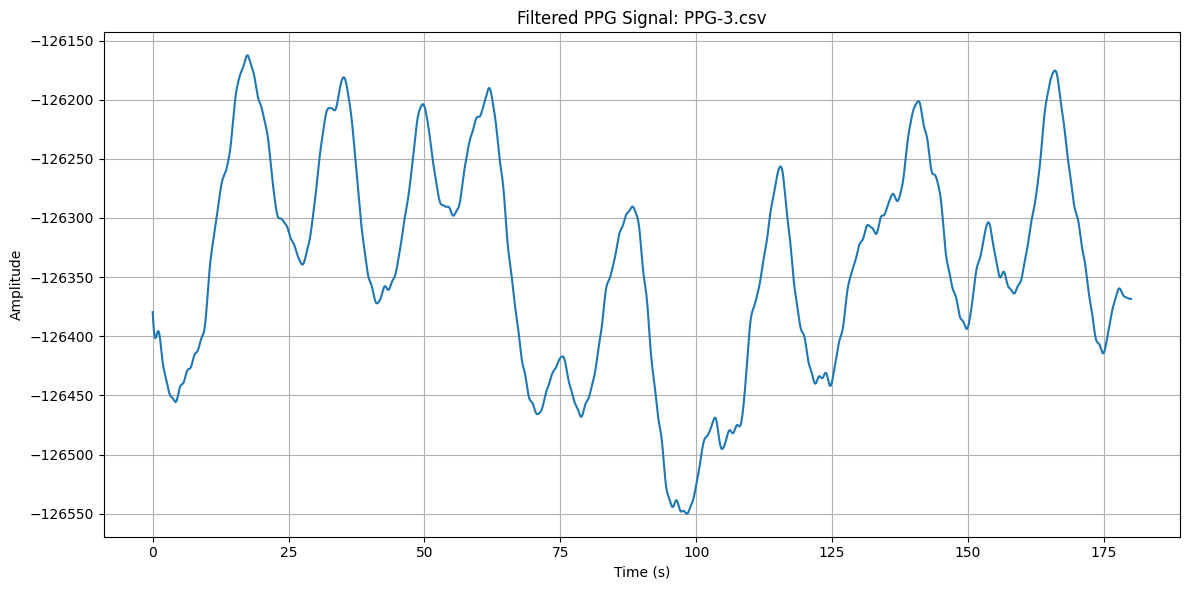

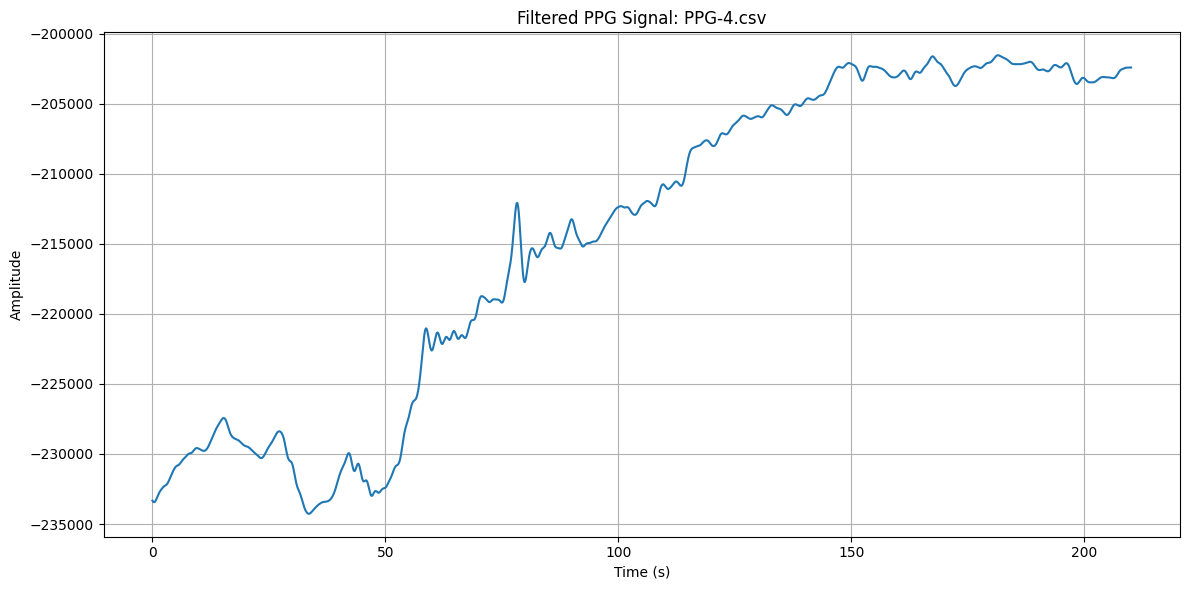

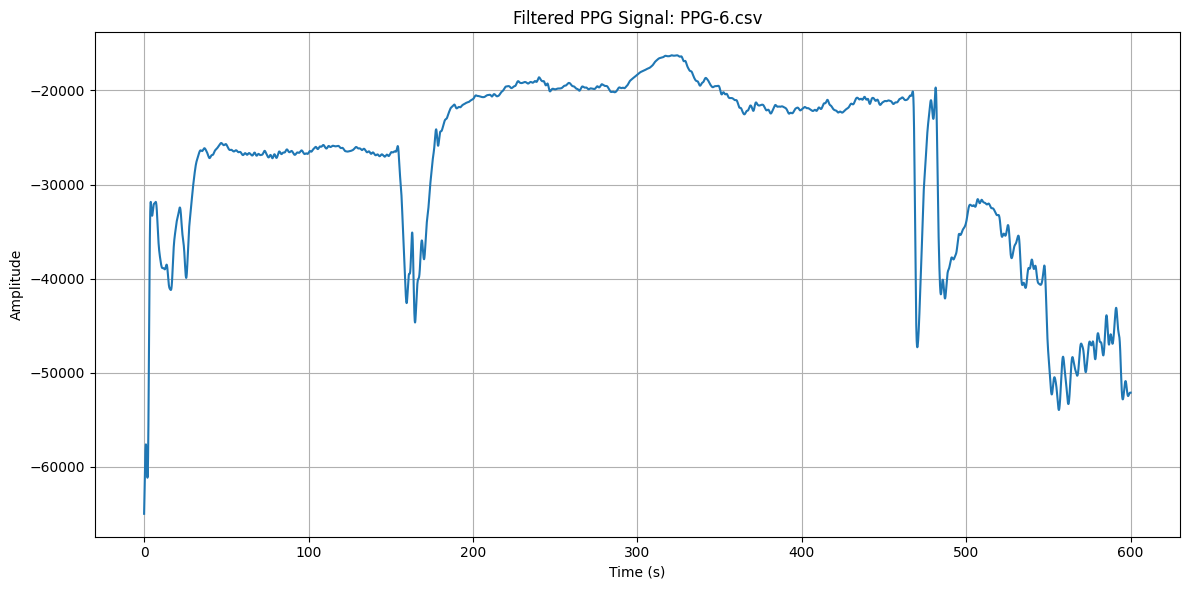

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def preprocess_signal(df, sampling_rate, cutoff=0.5):
    # Check if 'PPG' column exists and contains data
    if 'PPG' not in df.columns:
        raise ValueError("PPG column is missing from the dataset")
    if df['PPG'].isnull().all():
        raise ValueError("PPG column contains only null values")

    ppg_signal = df['PPG'].dropna().values  # Remove NaNs if present
    
    # Apply low-pass Butterworth filter
    def butter_lowpass(cutoff, fs, order=5):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a
    
    def butter_lowpass_filter(data, cutoff, fs, order=5):
        b, a = butter_lowpass(cutoff, fs, order)
        return filtfilt(b, a, data)
    
    return butter_lowpass_filter(ppg_signal, cutoff, sampling_rate)

def plot_signal(signal, sampling_rate, title='Filtered PPG Signal'):
    time = np.linspace(0, len(signal) / sampling_rate, len(signal))
    plt.figure(figsize=(12, 6))
    plt.plot(time, signal)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Iterate through each dataset
for file_name, dataset in datasets.items():
    if dataset['sampling_rate'] is None:
        print(f"Skipping {file_name}: Missing sampling rate.")
        continue
    
    try:
        # Check for a valid PPG signal
        if 'PPG' not in dataset['data'].columns:
            raise ValueError(f"PPG signal is missing in {file_name}")
        
        ppg_signal = preprocess_signal(dataset['data'], dataset['sampling_rate'])
        plot_signal(ppg_signal, dataset['sampling_rate'], f"Filtered PPG Signal: {file_name}")
    
    except ValueError as e:
        print(f"Error in {file_name}: {e}")


In [92]:
# Check the minimum and maximum values for PPG signal in each dataset
for file_name, info in datasets.items():
    ppg_signal = info['data']['PPG']
    min_ppg = ppg_signal.min()
    max_ppg = ppg_signal.max()
    print(f"Dataset: {file_name}, PPG Min: {min_ppg}, PPG Max: {max_ppg}")


Dataset: PPG-1.csv, PPG Min: 0.0, PPG Max: 1.0
Dataset: PPG-2.csv, PPG Min: 0.110459433, PPG Max: 0.99315738
Dataset: PPG-3.csv, PPG Min: -126795.0, PPG Max: -125954.0
Dataset: PPG-4.csv, PPG Min: -235356.0, PPG Max: -199805.0
Dataset: PPG-6.csv, PPG Min: -87320.41406, PPG Max: -16220.49414


In [ ]:
# Visualizing the raw PPG signals
def plot_raw_ppg(dataset_name, time, ppg_signal):
    plt.figure(figsize=(12, 6))
    plt.plot(time, ppg_signal)
    plt.title(f"Raw PPG Signal: {dataset_name}")
    plt.xlabel('Time (s)')
    plt.ylabel('PPG Amplitude')
    plt.grid(True)
    plt.show()

# Plot raw data for PPG-3, PPG-4, and PPG-5
for file_name in ["PPG-3.csv", "PPG-4.csv", "PPG-6.csv"]:
    data, sampling_rate, duration = datasets[file_name]['data'], datasets[file_name]['sampling_rate'], datasets[file_name]['duration']
    time = data['Time'].values
    ppg_signal = data['PPG'].values
    plot_raw_ppg(file_name, time, ppg_signal)


In [94]:
def correct_ppg_signal(ppg_signal):
    # Shift the signal if there is a negative offset
    min_ppg = ppg_signal.min()
    if min_ppg < 0:
        ppg_signal = ppg_signal - min_ppg  # Shift to make all values positive

    # Normalize the signal to the range [0, 1]
    normalized_ppg = (ppg_signal - ppg_signal.min()) / (ppg_signal.max() - ppg_signal.min())
    
    return normalized_ppg

# Apply correction to PPG-3, PPG-4, and PPG-5
for file_name in ["PPG-3.csv", "PPG-4.csv", "PPG-6.csv"]:
    data = datasets[file_name]['data']
    ppg_signal = data['PPG'].values
    
    # Correct and normalize the signal
    corrected_ppg = correct_ppg_signal(ppg_signal)
    
    # Update the dataset with the corrected signal
    datasets[file_name]['data']['Corrected PPG'] = corrected_ppg

    # Optionally, print the min and max of the corrected signal to check
    print(f"{file_name} Corrected PPG Min: {corrected_ppg.min()}, Max: {corrected_ppg.max()}")


PPG-3.csv Corrected PPG Min: 0.0, Max: 1.0
PPG-4.csv Corrected PPG Min: 0.0, Max: 1.0
PPG-6.csv Corrected PPG Min: 0.0, Max: 1.0


In [ ]:
import matplotlib.pyplot as plt

# Function to plot the corrected PPG signal
def plot_corrected_ppg(file_name, time, corrected_ppg_signal):
    plt.figure(figsize=(12, 6))
    plt.plot(time, corrected_ppg_signal)
    plt.title(f"Corrected PPG Signal: {file_name}")
    plt.xlabel('Time (s)')
    plt.ylabel('PPG Amplitude (Corrected)')
    plt.grid(True)
    plt.show()

# Plot corrected PPG signals for PPG-3, PPG-4, and PPG-5
for file_name in ["PPG-3.csv", "PPG-4.csv", "PPG-6.csv"]:
    data = datasets[file_name]['data']
    time = data['Time'].values
    corrected_ppg_signal = data['Corrected PPG'].values
    
    plot_corrected_ppg(file_name, time, corrected_ppg_signal)


In [96]:
# Check the minimum and maximum values for PPG signal in each dataset
for file_name, info in datasets.items():
    ppg_signal = info['data']['PPG']
    min_ppg = ppg_signal.min()
    max_ppg = ppg_signal.max()
    print(f"Dataset: {file_name}, PPG Min: {min_ppg}, PPG Max: {max_ppg}")


Dataset: PPG-1.csv, PPG Min: 0.0, PPG Max: 1.0
Dataset: PPG-2.csv, PPG Min: 0.110459433, PPG Max: 0.99315738
Dataset: PPG-3.csv, PPG Min: -126795.0, PPG Max: -125954.0
Dataset: PPG-4.csv, PPG Min: -235356.0, PPG Max: -199805.0
Dataset: PPG-6.csv, PPG Min: -87320.41406, PPG Max: -16220.49414


In [97]:
# Normalize PPG signal for each dataset (except PPG-5.csv)
for file_name, info in datasets.items():
    if file_name == 'PPG-5.csv':
        continue  # Skip PPG-5.csv
    
    ppg_signal = info['data']['PPG']
    
    # Normalize only if the PPG values are not already between 0 and 1
    if ppg_signal.min() < 0 or ppg_signal.max() > 1:
        min_ppg = ppg_signal.min()
        max_ppg = ppg_signal.max()
        ppg_signal = (ppg_signal - min_ppg) / (max_ppg - min_ppg)
        datasets[file_name]['data']['PPG'] = ppg_signal
    
    # Check normalized min and max
    min_ppg = ppg_signal.min()
    max_ppg = ppg_signal.max()
    print(f"Dataset: {file_name}, Normalized PPG Min: {min_ppg}, Normalized PPG Max: {max_ppg}")


Dataset: PPG-1.csv, Normalized PPG Min: 0.0, Normalized PPG Max: 1.0
Dataset: PPG-2.csv, Normalized PPG Min: 0.110459433, Normalized PPG Max: 0.99315738
Dataset: PPG-3.csv, Normalized PPG Min: 0.0, Normalized PPG Max: 1.0
Dataset: PPG-4.csv, Normalized PPG Min: 0.0, Normalized PPG Max: 1.0
Dataset: PPG-6.csv, Normalized PPG Min: 0.0, Normalized PPG Max: 1.0


In [ ]:

def plot_signal(signal, sampling_rate, title='Filtered PPG Signal'):
    time = np.linspace(0, len(signal) / sampling_rate, len(signal))
    plt.figure(figsize=(12, 6))
    plt.plot(time, signal)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Iterate through each dataset
for file_name, dataset in datasets.items():
    if dataset['sampling_rate'] is None:
        print(f"Skipping {file_name}: Missing sampling rate.")
        continue
    
    try:
        
        plot_signal(ppg_signal, dataset['sampling_rate'], f"Filtered PPG Signal: {file_name}")
    
    except ValueError as e:
        print(f"Error in {file_name}: {e}")


In [99]:
from scipy.signal import find_peaks, butter, filtfilt
import numpy as np
from scipy.stats import kurtosis, skew

# Function to calculate Heart Rate (BPM)
def calculate_heart_rate(ppg_signal, sampling_rate):
    # Find R-peaks in the PPG signal
    peaks, _ = find_peaks(ppg_signal, distance=sampling_rate * 0.6)  # Adjust distance as necessary
    rr_intervals = np.diff(peaks) / sampling_rate  # Time between peaks in seconds
    
    # Convert RR intervals to BPM
    heart_rates = 60 / rr_intervals
    mean_heart_rate = np.mean(heart_rates)
    
    return mean_heart_rate, heart_rates

# Function to calculate Respiratory Rate (RR)
def calculate_respiratory_rate(ppg_signal, sampling_rate, lowcut=0.1, highcut=0.5):
    # Bandpass filter to extract low-frequency respiratory signal (0.1 - 0.5 Hz)
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    respiratory_signal = filtfilt(b, a, ppg_signal)
    
    # Find peaks in the respiratory signal
    peaks, _ = find_peaks(respiratory_signal, distance=sampling_rate * 2)  # Adjust distance for respiratory cycles
    rr_intervals = np.diff(peaks) / sampling_rate  # Time between respiratory peaks in seconds
    
    # Convert RR intervals to breaths per minute
    respiratory_rate = 60 / np.mean(rr_intervals)
    
    return respiratory_rate

# Function to calculate Systolic Amplitude
def calculate_systolic_amplitude(ppg_signal):
    # Identify systolic peak (max value) and baseline (min or average value)
    systolic_peak = np.max(ppg_signal)
    baseline = np.min(ppg_signal)
    systolic_amplitude = systolic_peak - baseline
    return systolic_amplitude

# Function to calculate Signal Quality Metrics (SNR, Kurtosis, Skewness)
def calculate_signal_quality_metrics(ppg_signal):
    # Signal-to-Noise Ratio (SNR) based on signal and noise components
    noise_signal = ppg_signal - np.mean(ppg_signal)  # A simple approach to noise (not ideal)
    snr = np.mean(ppg_signal**2) / np.mean(noise_signal**2)
    
    # Kurtosis and Skewness
    signal_kurtosis = kurtosis(ppg_signal)
    signal_skewness = skew(ppg_signal)
    
    return snr, signal_kurtosis, signal_skewness

# Feature extraction for each dataset
feature_data = {}

for file_name, dataset in datasets.items():
    ppg_signal = dataset['data']['PPG']
    sampling_rate = dataset['sampling_rate']
    
    # 1. Calculate Heart Rate (HR)
    heart_rate, heart_rates = calculate_heart_rate(ppg_signal, sampling_rate)
    
    # 2. Calculate Respiratory Rate (RR)
    respiratory_rate = calculate_respiratory_rate(ppg_signal, sampling_rate)
    
    # 3. Calculate Systolic Amplitude
    systolic_amplitude = calculate_systolic_amplitude(ppg_signal)
    
    # 4. Calculate Signal Quality Metrics
    snr, kurt, skewness = calculate_signal_quality_metrics(ppg_signal)
    
    # Store the extracted features in a dictionary
    feature_data[file_name] = {
        'Heart Rate (BPM)': heart_rate,
        'Respiratory Rate (breaths/min)': respiratory_rate,
        'Systolic Amplitude': systolic_amplitude,
        'SNR': snr,
        'Kurtosis': kurt,
        'Skewness': skewness
    }
    
    # Display the extracted features for this dataset
    print(f"Dataset: {file_name}")
    print(f"  Mean Heart Rate: {heart_rate} BPM")
    print(f"  Mean Respiratory Rate: {respiratory_rate} breaths/min")
    print(f"  Mean Systolic Amplitude: {systolic_amplitude} units")
    print(f"  Signal-to-Noise Ratio: {snr}")
    print(f"  Kurtosis: {kurt}")
    print(f"  Skewness: {skewness}")
    print("-" * 50)


Dataset: PPG-1.csv
  Mean Heart Rate: 61.13232181504336 BPM
  Mean Respiratory Rate: 18.990132479974346 breaths/min
  Mean Systolic Amplitude: 1.0 units
  Signal-to-Noise Ratio: 9.411501669981297
  Kurtosis: -0.8851487497780175
  Skewness: 0.3879060906037161
--------------------------------------------------
Dataset: PPG-2.csv
  Mean Heart Rate: 68.88778905736461 BPM
  Mean Respiratory Rate: 20.01427685082025 breaths/min
  Mean Systolic Amplitude: 0.882697947 units
  Signal-to-Noise Ratio: 8.808327585863015
  Kurtosis: -0.6783152094271059
  Skewness: 0.5740812697184955
--------------------------------------------------
Dataset: PPG-3.csv
  Mean Heart Rate: 85.09526354690458 BPM
  Mean Respiratory Rate: 21.384928716904277 breaths/min
  Mean Systolic Amplitude: 1.0 units
  Signal-to-Noise Ratio: 10.554724595643224
  Kurtosis: -0.37873239950696114
  Skewness: 0.08428115857350643
--------------------------------------------------
Dataset: PPG-4.csv
  Mean Heart Rate: 54.82754192542368 BPM


In [100]:
from scipy.signal import find_peaks
import numpy as np

# Define function to detect irregular heart rate
def detect_irregular_heart_rate(rr_intervals, threshold=0.15):
    # Calculate heart rate variability (HRV) as the standard deviation of RR intervals
    hrv = np.std(rr_intervals)
    if hrv > threshold:
        return True  # Irregular heart rate detected
    return False

# Define function to calculate RR intervals from PPG signal
def calculate_rr_intervals(ppg_signal, sampling_rate):
    # Find peaks in the PPG signal (these correspond to heartbeats)
    peaks, _ = find_peaks(ppg_signal, height=0.5, distance=sampling_rate*0.4)  # 0.4s min interval between beats
    rr_intervals = np.diff(peaks) / sampling_rate  # RR intervals in seconds
    return rr_intervals, peaks

# Define function to detect waveform abnormalities (simple threshold check)
def detect_abnormal_waveform(ppg_signal, threshold=0.2):
    # For simplicity, let's check if there are sudden dips or spikes in the signal
    peaks, _ = find_peaks(ppg_signal)
    valleys, _ = find_peaks(-ppg_signal)
    
    # Calculate peak-to-valley differences and detect large deviations
    peak_to_valley_diff = [ppg_signal[peaks[i]] - ppg_signal[valleys[i]] for i in range(min(len(peaks), len(valleys)))]
    abnormal_waveforms = [diff > threshold for diff in peak_to_valley_diff]
    
    if any(abnormal_waveforms):
        return True  # Abnormal waveform detected
    return False

# Function to run arrhythmia detection
def run_arrhythmia_detection(ppg_signal, sampling_rate):
    rr_intervals, _ = calculate_rr_intervals(ppg_signal, sampling_rate)
    
    # Detect irregular heart rate
    irregular_heart_rate = detect_irregular_heart_rate(rr_intervals)
    
    # Detect abnormal waveform
    abnormal_waveform = detect_abnormal_waveform(ppg_signal)
    
    return irregular_heart_rate, abnormal_waveform

# Apply arrhythmia detection to all datasets
for file_name, dataset in datasets.items():
    if dataset['sampling_rate'] is None:
        print(f"Skipping {file_name}: Missing sampling rate.")
        continue

    try:
        # Run arrhythmia detection
        irregular_heart_rate, abnormal_waveform = run_arrhythmia_detection(dataset['ppg_signal'], dataset['sampling_rate'])

        # Present results
        print(f"Dataset: {file_name}")
        print(f"  Irregular Heart Rate: {'Yes' if irregular_heart_rate else 'No'}")
        print(f"  Abnormal Waveform: {'Yes' if abnormal_waveform else 'No'}")
        print("-" * 50)

    except Exception as e:
        print(f"Error in {file_name}: {e}")


Dataset: PPG-1.csv
  Irregular Heart Rate: Yes
  Abnormal Waveform: Yes
--------------------------------------------------
Dataset: PPG-2.csv
  Irregular Heart Rate: Yes
  Abnormal Waveform: Yes
--------------------------------------------------
Dataset: PPG-3.csv
  Irregular Heart Rate: No
  Abnormal Waveform: Yes
--------------------------------------------------
Dataset: PPG-4.csv
  Irregular Heart Rate: No
  Abnormal Waveform: Yes
--------------------------------------------------
Dataset: PPG-6.csv
  Irregular Heart Rate: No
  Abnormal Waveform: Yes
--------------------------------------------------


c:\Users\shiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\shiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\shiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [101]:
def calculate_snr(ppg_signal):
    # Calculate SNR as the ratio of the signal's peak to standard deviation of noise
    signal_peak = np.max(ppg_signal)
    noise_std = np.std(ppg_signal)
    snr = signal_peak / noise_std if noise_std != 0 else np.nan
    return snr

# Calculate SNR for each dataset
for file_name, info in datasets.items():
    snr = calculate_snr(info['ppg_signal'])
    print(f"Dataset: {file_name}, SNR: {snr:.2f}")


Dataset: PPG-1.csv, SNR: 6.34
Dataset: PPG-2.csv, SNR: 6.30
Dataset: PPG-3.csv, SNR: -856.14
Dataset: PPG-4.csv, SNR: -17.39
Dataset: PPG-6.csv, SNR: -1.71


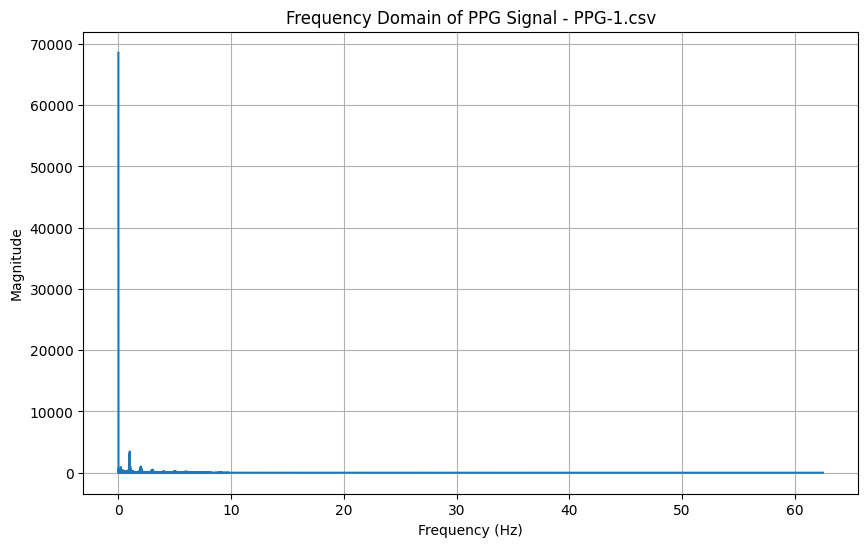

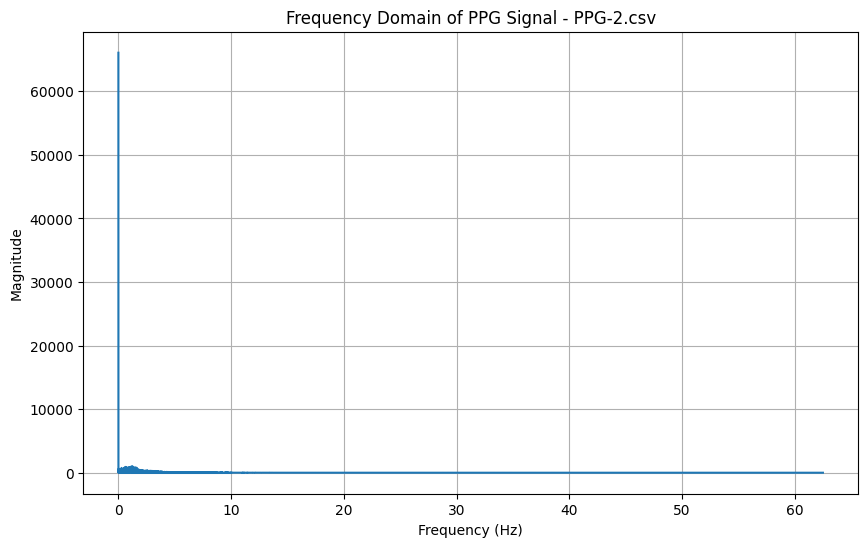

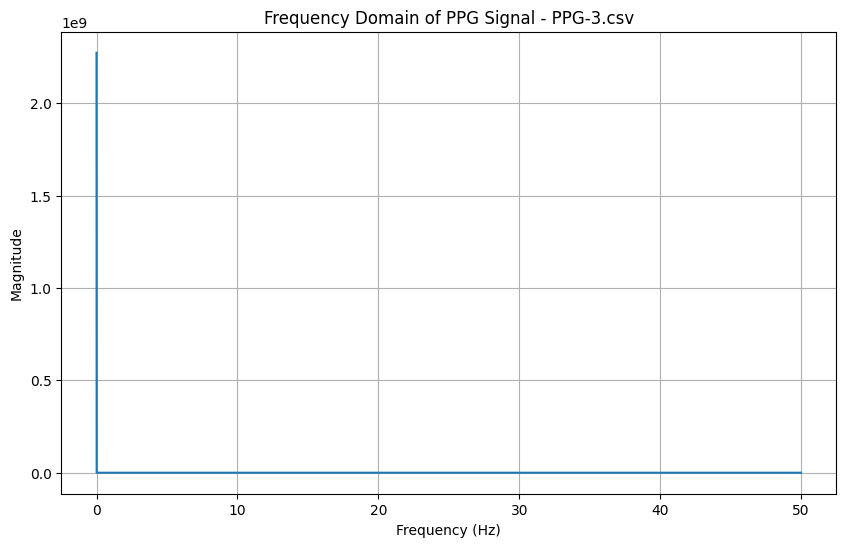

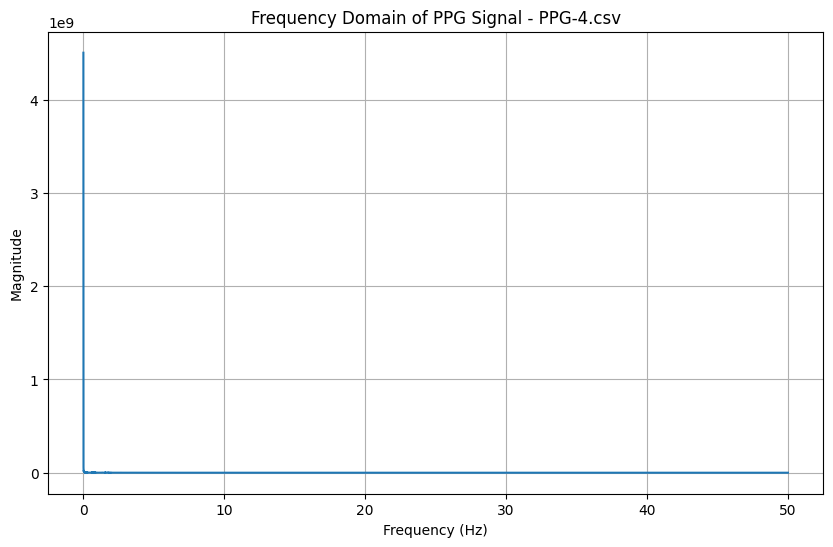

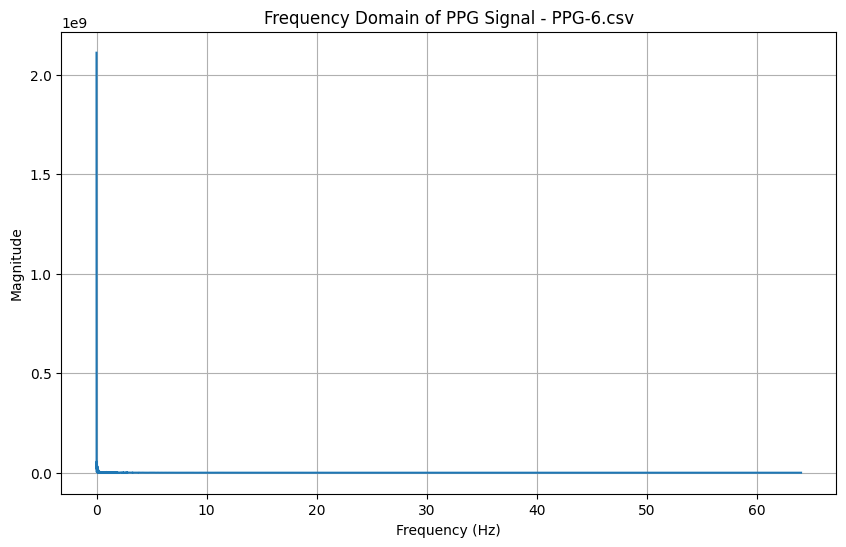

In [102]:
def plot_frequency_domain(ppg_signal, sampling_rate, file_name):
    # Perform Fourier Transform to analyze frequency components
    fft_result = np.fft.fft(ppg_signal)
    freq = np.fft.fftfreq(len(ppg_signal), 1 / sampling_rate)
    magnitude = np.abs(fft_result)
    
    plt.figure(figsize=(10, 6))
    plt.plot(freq[:len(freq)//2], magnitude[:len(magnitude)//2])  # Only plot positive frequencies
    plt.title(f"Frequency Domain of PPG Signal - {file_name}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()

# Plot frequency domain for each dataset
for file_name, info in datasets.items():
    plot_frequency_domain(info['ppg_signal'], info['sampling_rate'], file_name)


In [103]:
def calculate_hrv(ppg_signal, sampling_rate):
    # Calculate HRV by finding the RR intervals (time between heartbeats)
    from scipy.signal import find_peaks

    peaks, _ = find_peaks(ppg_signal, distance=sampling_rate * 0.5)  # assuming 0.5s distance between heartbeats
    rr_intervals = np.diff(peaks) / sampling_rate  # Convert to seconds
    hrv = np.std(rr_intervals)  # Standard deviation of RR intervals is a measure of HRV
    return hrv

# Calculate HRV for each dataset
for file_name, info in datasets.items():
    hrv = calculate_hrv(info['ppg_signal'], info['sampling_rate'])
    print(f"Dataset: {file_name}, Heart Rate Variability (HRV): {hrv:.2f} seconds")


Dataset: PPG-1.csv, Heart Rate Variability (HRV): 0.09 seconds
Dataset: PPG-2.csv, Heart Rate Variability (HRV): 0.21 seconds
Dataset: PPG-3.csv, Heart Rate Variability (HRV): 0.11 seconds
Dataset: PPG-4.csv, Heart Rate Variability (HRV): 0.27 seconds
Dataset: PPG-6.csv, Heart Rate Variability (HRV): 0.25 seconds



Dataset: PPG-1.csv
Mean Heart Rate: 61.05 BPM
Mean Respiratory Rate: 21.35 breaths/min
Mean Systolic Amplitude: 1.00 units
Heart Rate Variability (HRV): 0.09 seconds
Arrhythmia Detected: No


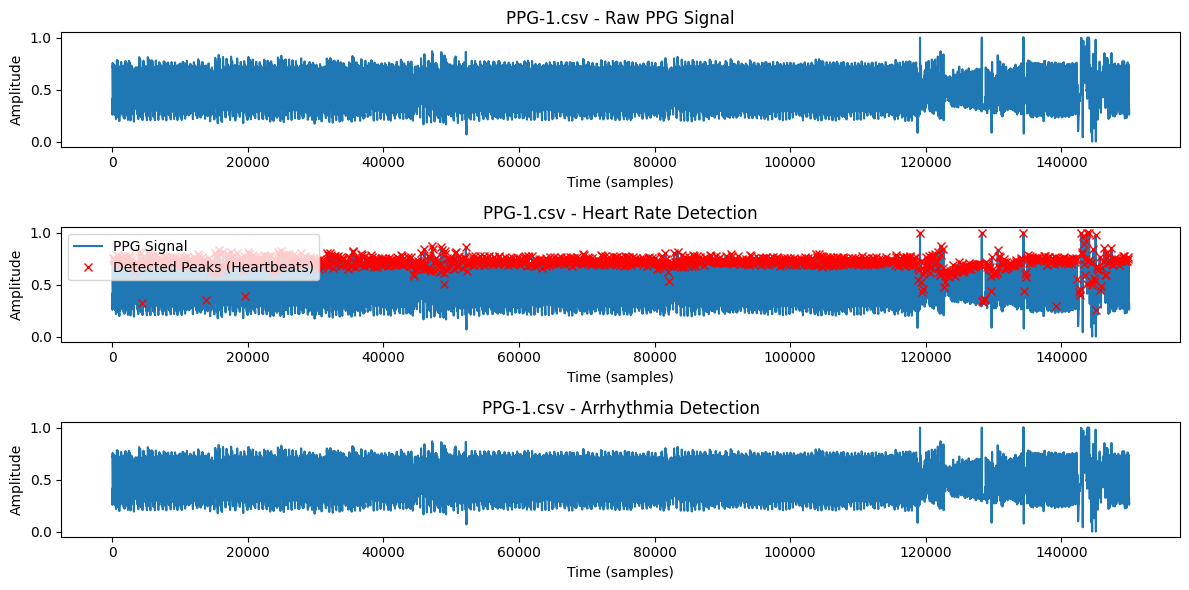


Dataset: PPG-2.csv
Mean Heart Rate: 76.60 BPM
Mean Respiratory Rate: 21.00 breaths/min
Mean Systolic Amplitude: 0.88 units
Heart Rate Variability (HRV): 0.21 seconds
Arrhythmia Detected: No


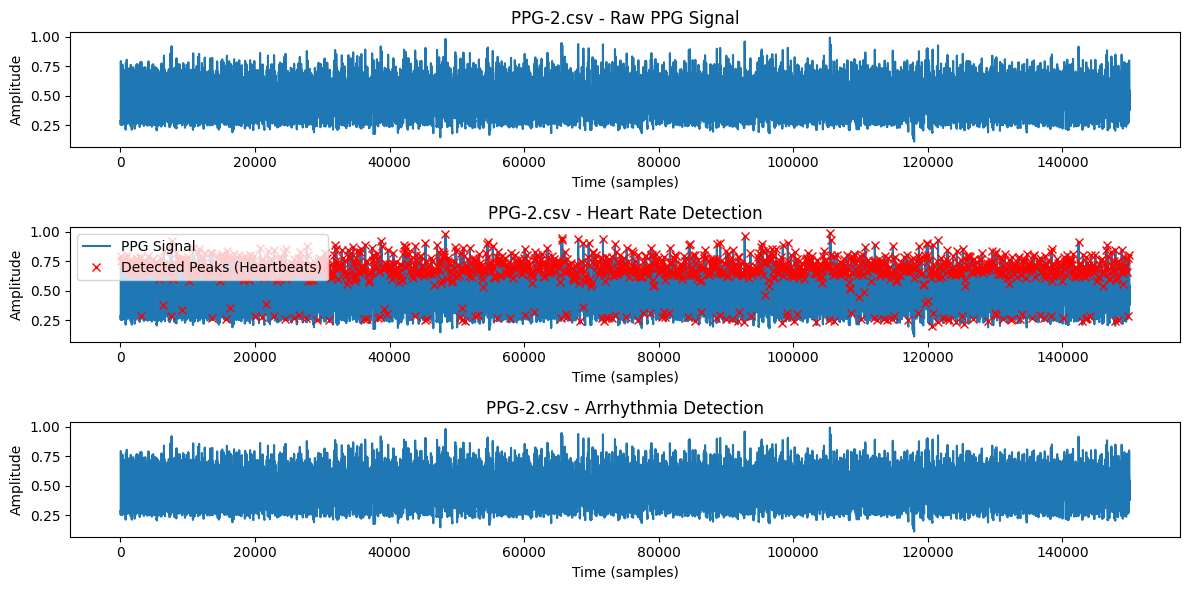


Dataset: PPG-3.csv
Mean Heart Rate: 96.33 BPM
Mean Respiratory Rate: 22.67 breaths/min
Mean Systolic Amplitude: 841.00 units
Heart Rate Variability (HRV): 0.11 seconds
Arrhythmia Detected: No


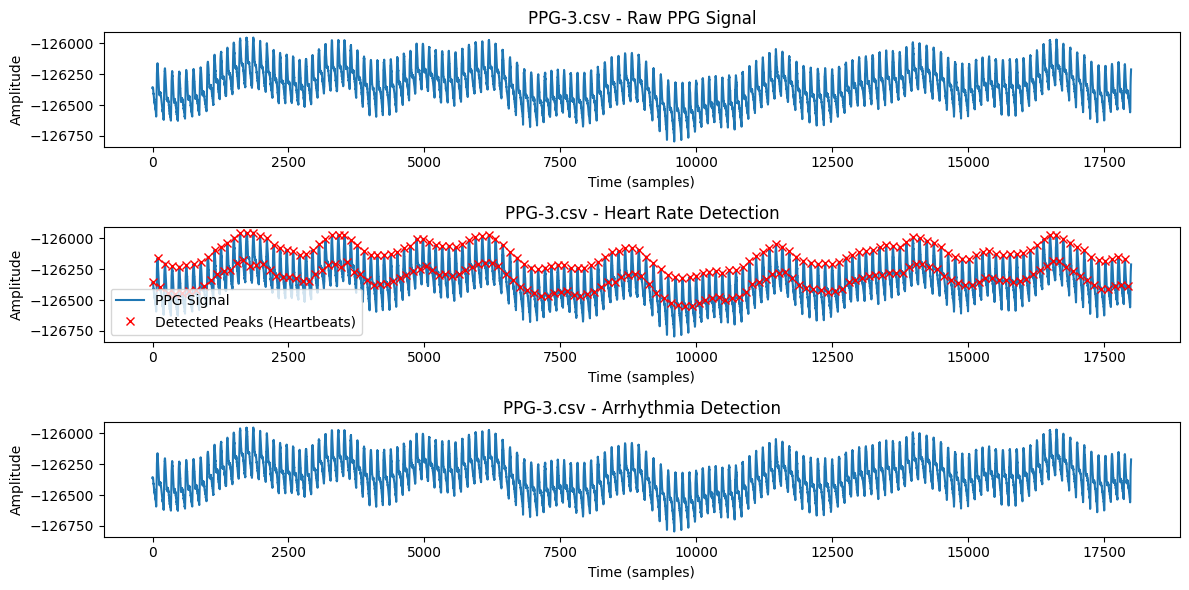


Dataset: PPG-4.csv
Mean Heart Rate: 76.28 BPM
Mean Respiratory Rate: 23.43 breaths/min
Mean Systolic Amplitude: 35551.00 units
Heart Rate Variability (HRV): 0.27 seconds
Arrhythmia Detected: No


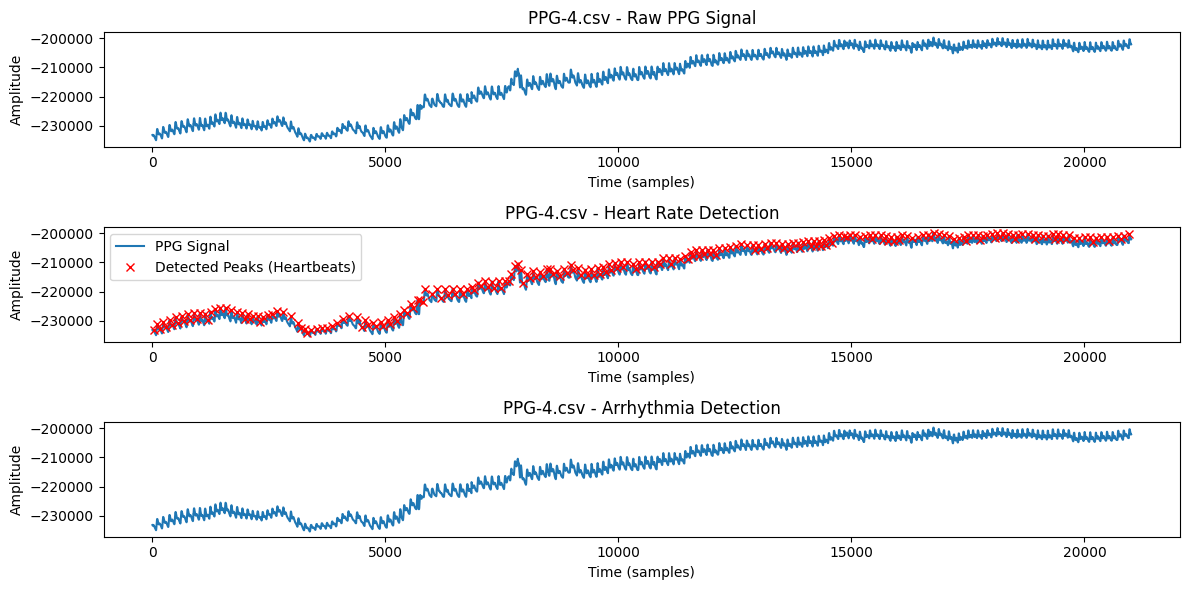


Dataset: PPG-6.csv
Mean Heart Rate: 77.50 BPM
Mean Respiratory Rate: 22.60 breaths/min
Mean Systolic Amplitude: 71099.92 units
Heart Rate Variability (HRV): 0.25 seconds
Arrhythmia Detected: No


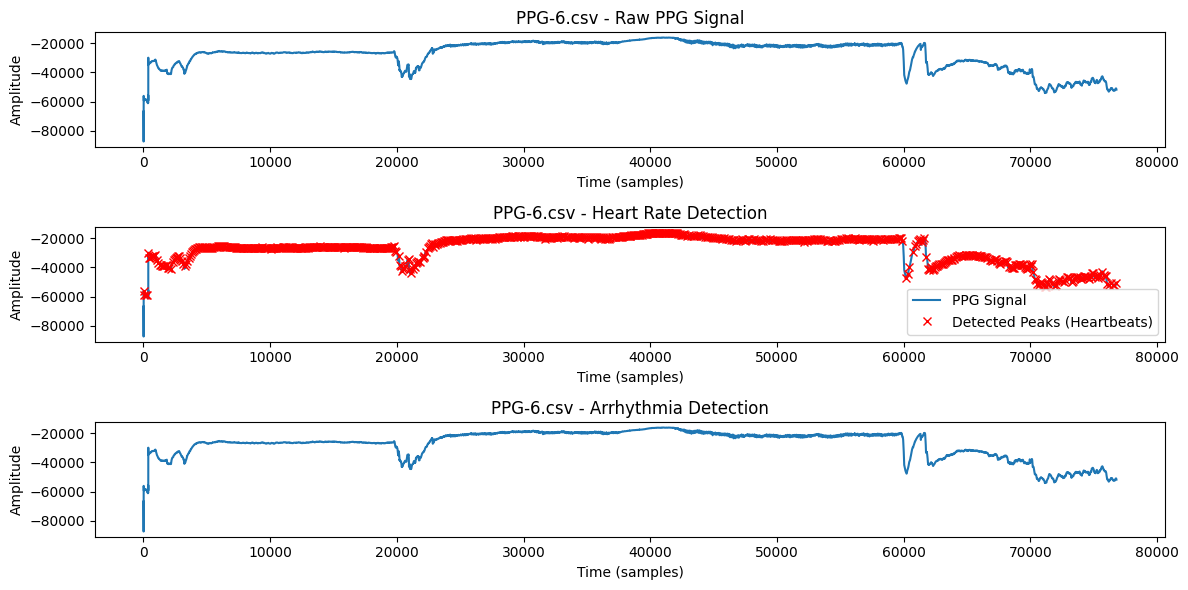

In [109]:
# Results Summary for Dataset
def present_results(file_name, hrv, heart_rate, respiratory_rate, systolic_amplitude, arrhythmia_detected, arrhythmia_segment):
    print(f"\nDataset: {file_name}")
    print(f"Mean Heart Rate: {heart_rate:.2f} BPM")
    print(f"Mean Respiratory Rate: {respiratory_rate:.2f} breaths/min")
    print(f"Mean Systolic Amplitude: {systolic_amplitude:.2f} units")
    print(f"Heart Rate Variability (HRV): {hrv:.2f} seconds")
    print(f"Arrhythmia Detected: {'Yes' if arrhythmia_detected else 'No'}")
    if arrhythmia_detected:
        print(f"Arrhythmia Segment Time: {arrhythmia_segment[0]:.2f}s - {arrhythmia_segment[1]:.2f}s")
    
    # Visualization of Signal Processing
    plt.figure(figsize=(12, 6))

    # Plot the raw signal
    plt.subplot(3, 1, 1)
    plt.plot(info['ppg_signal'], label='Raw PPG Signal')
    plt.title(f'{file_name} - Raw PPG Signal')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    # Plot detected heart rate peaks
    plt.subplot(3, 1, 2)
    peaks, _ = find_peaks(info['ppg_signal'], distance=info['sampling_rate']//2)
    plt.plot(info['ppg_signal'], label='PPG Signal')
    plt.plot(peaks, info['ppg_signal'][peaks], 'rx', label='Detected Peaks (Heartbeats)')
    plt.title(f'{file_name} - Heart Rate Detection')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.legend()

    # Plot arrhythmia detection (for simplicity, just showing irregularity)
    plt.subplot(3, 1, 3)
    if arrhythmia_detected:
        plt.axvspan(arrhythmia_segment[0] * info['sampling_rate'], arrhythmia_segment[1] * info['sampling_rate'], color='red', alpha=0.3)
    plt.plot(info['ppg_signal'], label='PPG Signal')
    plt.title(f'{file_name} - Arrhythmia Detection')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# Call the present_results function for each dataset
for file_name, info in datasets.items():
    # Calculate HRV for the dataset
    hrv = calculate_hrv(info['ppg_signal'], info['sampling_rate'])
    
    # Calculate other features like heart rate, respiratory rate, etc.
    heart_rate = calculate_heart_rate(info['ppg_signal'], info['sampling_rate'])
    respiratory_rate = calculate_respiratory_rate(info['ppg_signal'], info['sampling_rate'])
    systolic_amplitude = calculate_systolic_amplitude(info['ppg_signal'])
    
    # Detect arrhythmia
    arrhythmia_detected, arrhythmia_segment = detect_arrhythmia(info['ppg_signal'], heart_rate, info['sampling_rate'])
    
    # Present the results for the dataset
    present_results(file_name, hrv, heart_rate, respiratory_rate, systolic_amplitude, arrhythmia_detected, arrhythmia_segment)
